# Create THERMOCALC KG1 phase diagram

Import required libraries:

In [1]:
import pyMelt as m
from pyMelt import phaseDiagramTools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [8]:
kg1 = pd.read_csv('kg1_thermocalc_grid.csv')
kg1.head()

,Unnamed: 0,pressure,temperature,X,cpx,cpx_Al2O3,cpx_CaO,cpx_Cr2O3,cpx_FeO,cpx_K2O,...,g_SiO2,g_TiO2,g_xAlM2,g_xCaM1,g_xCrM2,g_xFe3M2,g_xFeM1,g_xMgM1,g_xMgM2,g_xTiM2
0,10566,0.01,1050.1,NaN,0.11453,0.777073,18.439632,0.091563,5.321257,0.370267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22572,0.01,1055.0,NaN,0.11652,0.791166,18.411995,0.092835,5.335828,0.365026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22573,0.01,1060.0,NaN,0.11857,0.805720,18.383104,0.094132,5.350976,0.359784,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22574,0.01,1065.0,NaN,0.12064,0.820480,18.353528,0.095456,5.366414,0.354669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22575,0.01,1070.0,NaN,0.12274,0.835447,18.323255,0.096805,5.382170,0.349629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
for col in kg1.columns:
    if col == 'plc':
        kg1['pl'] = kg1['plc']
    elif col[:3] == 'plc':
        kg1['pl_'+col[4:]] = kg1[col]

Using lattice-strain model partition coefficients requires the pyrope proportion, which is more convenient to access directly:

In [10]:
# Properties needed to calculate garnet Ds
kg1['g_pyrope'] = kg1['g_xMgM1']
kg1['g_grossular'] = kg1['g_xCaM1'] - kg1['g_xCrM2'] - kg1['g_xFe3M2']
kg1['g_almandine'] = kg1['g_xFeM1']
kg1['g_uvarovite'] = kg1['g_xCrM2']
kg1['g_spessartine'] = 0.0
kg1['g_andradite'] = kg1['g_xFe3M2']

cols_to_sum = ['g_Al2O3', 'g_CaO', 'g_Cr2O3', 'g_FeO', 'g_K2O', 'g_MgO', 'g_Na2O', 'g_O', 'g_SiO2', 'g_TiO2']
g_totmass = kg1['g_Al2O3'] * m.chemistry.oxide_masses['Al2O3']

for col in cols_to_sum[1:]:
    g_totmass += kg1[col] * m.chemistry.oxide_masses[col[2:]]
    
kg1['g_FeO_wtpt'] = kg1['g_FeO'] * m.chemistry.oxide_masses['FeO'] / g_totmass * 100

# Properties needed for plagioclase Ds:
kg1['pl_anorthite'] = kg1['pl_x(Ca)']
kg1['pl_albite'] = kg1['pl_x(Na)']

# Properties needed for cpx Ds
kg1['liq_Mg#'] = kg1['liq_mgM'] / (kg1['liq_mgM'] + kg1['liq_feM'])

In [11]:
kg1_grid = phaseDiagramTools.gridsThermocalc(kg1, phases=['ol', 'opx', 'cpx', 'spn', 'g', 'ru', 'liq', 'pl'])

In [16]:
parameters = ['ol_mass', 'g_mass', 'cpx_mass', 'opx_mass', 'spn_mass', 'pl_mass', 'ru_mass',
              'liq_SiO2_wtpt', 'liq_MgO_wtpt', 'liq_FeO_wtpt', 'liq_Fe2O3_wtpt', 'liq_CaO_wtpt',
              'liq_Na2O_wtpt', 'liq_K2O_wtpt', 'liq_Cr2O3_wtpt', 'liq_Al2O3_wtpt', 'liq_TiO2_wtpt',
              'g_pyrope', 'g_grossular', 'g_almandine', 'g_uvarovite', 'g_spessartine', 'g_andradite', 'g_FeO_wtpt',
              'pl_anorthite', 'pl_albite',
              'liq_Mg#', 'cpx_xMgM1', 'cpx_xCaM2', 'cpx_xAlM1', 'temperature']
vars_edge_vals = ['g_pyrope', 'g_grossular', 'g_almandine', 'g_uvarovite', 'g_spessartine', 'g_andradite', 'g_FeO_wtpt',
                  'cpx_xMgM1', 'cpx_xCaM2', 'cpx_xAlM1', 'pl_anorthite', 'pl_albite']

In [17]:
phased = phaseDiagramTools.phaseDiagram(kg1_grid, parameters, vars_edge_vals=vars_edge_vals)

## Check the interpolated phase diagram

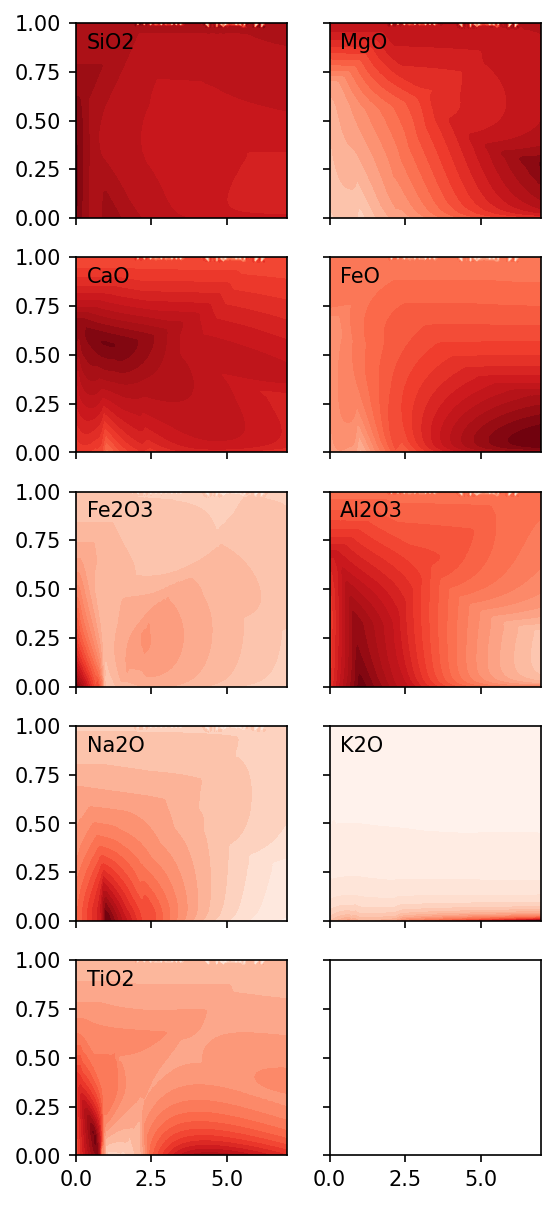

In [18]:
oxides = ['SiO2', 'MgO', 'CaO', 'FeO', 'Fe2O3', 'Al2O3', 'Na2O', 'K2O', 'TiO2']
p = np.linspace(0, 7, 100)
f = np.linspace(0, 1, 100)

pp, ff = np.meshgrid(p, f)

cc = np.zeros(np.shape(pp))

f, a = plt.subplots(5, 2, dpi=150, figsize=[4, 10], sharex='col', sharey='row')
a = np.ravel(a).tolist()


for n in range(len(oxides)):
    for i in range(np.shape(pp)[0]):
        for j in range(np.shape(pp)[1]):
            state = pd.Series({'P': pp[i,j],'F': ff[i,j]})
            cc[i,j] = phased('liq_' + oxides[n] + '_wtpt', state)
    
    a[n].contourf(pp, ff, cc, levels=25, cmap=plt.cm.Reds)
    a[n].text(0.05, 0.95, oxides[n], transform=a[n].transAxes, va='top', ha='left')

plt.show()

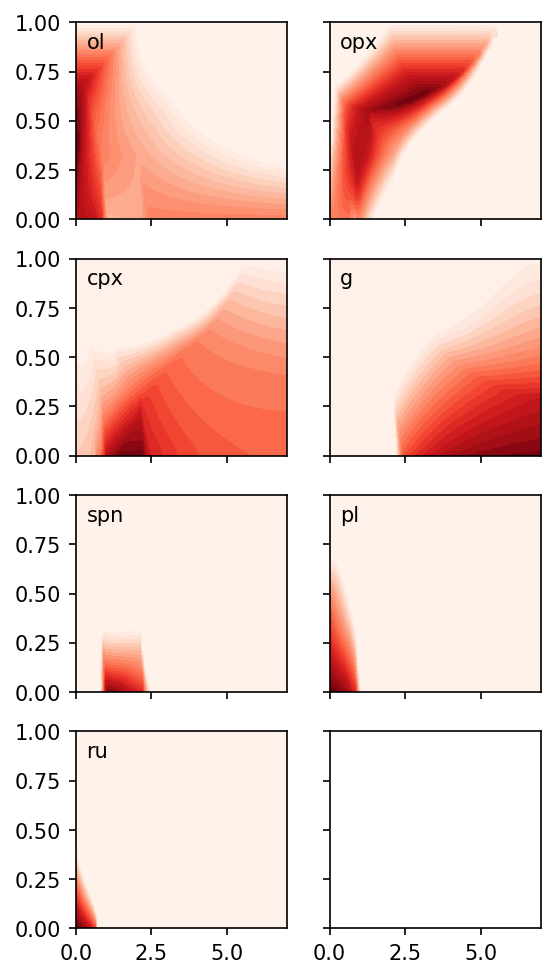

In [19]:
phases = ['ol', 'opx', 'cpx', 'g', 'spn', 'pl', 'ru']
p = np.linspace(0, 7, 100)
f = np.linspace(0, 1, 100)

pp, ff = np.meshgrid(p, f)

cc = np.zeros(np.shape(pp))

f, a = plt.subplots(4, 2, dpi=150, figsize=[4, 8], sharex='col', sharey='row')
a = np.ravel(a).tolist()


for n in range(len(phases)):
    for i in range(np.shape(pp)[0]):
        for j in range(np.shape(pp)[1]):
            state = pd.Series({'P': pp[i,j],'F': ff[i,j]})
            cc[i,j] = phased(phases[n] + '_mass', state)
    
    a[n].contourf(pp, ff, cc, levels=25, cmap=plt.cm.Reds)
    a[n].text(0.05, 0.95, phases[n], transform=a[n].transAxes, va='top', ha='left')

plt.show()

In [20]:
f = open( "thermocalc_kg1.p", "wb" )
pickle.dump(phased, f)
f.close()